In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [18]:
#pathdata = os.getcwd()+'/Data'
#os.chdir(pathdata)
df_gdp = pd.read_pickle('ecbnewdates_gdp.pkl')
#df_gdp.index = df_gdp['SurveyDate']
#df_gdp = df_gdp.drop('SurveyDate', axis=1)

In [19]:
df_gdp = df_gdp.dropna()

# load shocks

In [20]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
oisfactors

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3
Date,,,,,,,,,,,
2002-01-03,0.01,0.01,0.01,0.01,-0.00,-0.01,-0.01,2002-01-03,1.98,-2.01,-0.77
2002-02-07,0.00,0.01,0.00,0.01,0.01,0.02,0.02,2002-02-07,0.80,0.59,1.71
2002-03-07,0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,2002-03-07,0.50,-0.82,0.75
2002-04-04,-0.01,-0.01,-0.01,-0.02,-0.03,-0.02,-0.02,2002-04-04,-0.94,-1.10,-1.09
2002-05-02,0.00,0.02,0.04,0.07,0.07,0.06,0.05,2002-05-02,2.39,4.82,1.45
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,-0.00,0.00,0.00,-0.00,-0.01,-0.03,-0.03,2018-03-08,0.33,-0.23,-2.80
2018-04-26,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,2018-04-26,0.27,-0.31,0.42
2018-06-14,0.00,0.00,0.00,0.00,-0.00,-0.01,-0.01,2018-06-14,0.30,-0.30,-0.46


In [21]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
pcdf = pd.concat([pcdf, df_gdp], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)
#pcdf = pcdf.dropna(subset=['CY'])

In [10]:
def cumSums(results, first_element = 0):
    cumsumCI = np.zeros((8, 3))
    #first estimate c0
    samplesize = 43
    mean = results.params[first_element] 
    cov = results.cov_params()[first_element,first_element]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(43)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(43)
    cumsumCI[0, 0] = lowB
    cumsumCI[0, 1] = mean
    cumsumCI[0, 2] = upB
    #we continue for the other coefficients
    for i in range(first_element+1, first_element+8):
        #get the new mean
        mean = mean + results.params[i]
        #add the variance
        cov = cov + results.cov_params()[i,i]*samplesize
        #add the covariances
        for j in range(first_element, i):
            cov = cov + 2*results.cov_params()[j,i]*samplesize
        upB = mean + 1.96*np.sqrt(cov)/np.sqrt(43)
        lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(43)
        cumsumCI[i-first_element, 0] = lowB
        cumsumCI[i-first_element, 1] = mean
        cumsumCI[i-first_element, 2] = upB

    df = pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
    df = df.sort_index()
    plt.plot(df['Mean'], color='r');
    plt.fill_between(df.index, df['LowerB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['UpperB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.title('Inflation');

## GDP ECB Forecast

In [22]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 8)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        #r
        #error9 = mp*(rolling1-mp*(c2))
        #error10 = mp*(rolling2-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8))
        return g

#order data
#newdfpc = newdfpc.drop(['1Y'], axis = 1)
dataols = pcdf.copy()
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var, 'CurrY', '1Y'])
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2001-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1, 2, 3])==True)*1
dataols['D2'] = (dataols.index.month.isin([4, 5, 6])==True)*1
dataols['D3'] = (dataols.index.month.isin([7, 8, 9])==True)*1
dataols['D4'] = (dataols.index.month.isin([10, 11, 12])==True)*1
#dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
#dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4',  var]]
#exog = dataols[[var]]
endog = dataols[['CurrY', '1Y']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.043778
         Iterations: 1071
         Function evaluations: 1573
Optimization terminated successfully.
         Current function value: 0.017336
         Iterations: 144
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 0.015278
         Iterations: 533
         Function evaluations: 814
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 208
         Function evaluations: 348
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 120
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 0.053918
         Iterations: 189
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: 0.019113
         Iterations: 818
         Function evaluations: 1196
Optimization term

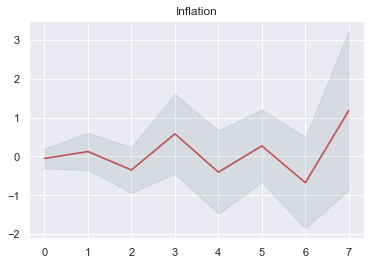

In [23]:
cumSums(res)

In [24]:
pd.DataFrame(res.tvalues, res.params )

,0
-0.05,-0.37
0.18,0.53
-0.47,-0.98
0.93,1.37
-0.99,-0.97
0.68,0.83
-0.95,-0.99
1.86,1.37


In [14]:
gdpdata = pd.read_pickle('test.pkl')

In [20]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 18)
        kwds.setdefault('k_params', 16)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7, c0_gdp, c1_gdp, c2_gdp, c3_gdp, c4_gdp, c5_gdp, c6_gdp, c7_gdp = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        currentY_gdp = endog[:,3]
        nextY_gdp = endog[:,4]        
        rolling1_gdp= endog[:,5]
        rolling2_gdp= endog[:,6]
        #monetary policy shock
        mp = exog[:,4]
        mp_gdp = exog[:,5]
        #next year forecasts ECB
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #GDP SPF
                #next year forecasts GDP
        error13 = dQ1*mp_gdp*(nextY_gdp-mp_gdp*(1/4*c1_gdp+1/2*c2_gdp+3/4*c3_gdp+1*c4_gdp+3/4*c5_gdp+1/2*c6_gdp+1/4*c7_gdp)*dQ1)
        error14 = dQ2*mp_gdp*(nextY_gdp-mp_gdp*(1/4*c0_gdp+1/2*c1_gdp+3/4*c2_gdp+1*c3_gdp+3/4*c4_gdp+1/2*c5_gdp+1/4*c6_gdp)*dQ2)
        error15 = dQ3*mp_gdp*(nextY_gdp-mp_gdp*(1/2*c0_gdp+3/4*c1_gdp+1*c2_gdp+3/4*c3_gdp+1/2*c4_gdp+1/4*c5_gdp)*dQ3)
        error16 = dQ4*mp_gdp*(nextY_gdp-mp_gdp*(3/4*c0_gdp+1*c1_gdp+3/4*c2_gdp+1/2*c3_gdp+1/4*c4_gdp)*dQ4)
        #current year forecasts
        error9 = dQ1*mp_gdp*(currentY_gdp-mp_gdp*(c0_gdp+3/4*c1_gdp+1/2*c2_gdp+1/4*c3_gdp)*dQ1)
        error10 = dQ2*mp_gdp*(currentY_gdp-mp_gdp*(3/4*c0_gdp+1/2*c1_gdp+1/4*c2_gdp)*dQ2)
        error11 = dQ3*mp_gdp*(currentY_gdp-mp_gdp*(1/2*c0_gdp+1/4*c1_gdp)*dQ3)
        error12 = dQ4*mp_gdp*(currentY_gdp-mp_gdp*(1/4*c0_gdp)*dQ4)        
        #rolling Qs
        error17 = mp_gdp*(rolling1_gdp-mp_gdp*(c2_gdp))
        error18 = mp_gdp*(rolling2_gdp-mp_gdp*(c6_gdp))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10, error11, error12,
                            error13, error14, error15, error16, error17, error18))
        return g


dataols = pd.merge_asof(df_gdp, pcdf, left_index=True, right_index = True)
var = 'ConfFactor2_y'
dataols = dataols.dropna(subset = [var, 'CurrY', '1Y_y'])
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2001-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1, 2, 3])==True)*1
dataols['D2'] = (dataols.index.month.isin([4, 5, 6])==True)*1
dataols['D3'] = (dataols.index.month.isin([7, 8, 9])==True)*1
dataols['D4'] = (dataols.index.month.isin([10, 11, 12])==True)*1

exog = dataols[['D1', 'D2', 'D3', 'D4',  var, 'ConfFactor2_x']].copy()
#exog = dataols[[var]]
endog = dataols[['CurrY', '1Y_y', 'CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'R1_GDP', 'R2_GDP']].copy()
model = mpGMM(endog, exog,  None)

beta0 = np.zeros((1,16))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                                                   'c0_gdp', 'c1_gdp', 'c2_gdp', 'c3_gdp', 'c4_gdp', 'c5_gdp', 'c6_gdp', 'c7_gdp',]))

AttributeError: 'RangeIndex' object has no attribute 'month'

In [89]:
rmatrix = np.array([[1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1]])

res.t_test(rmatrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2539      0.224      1.135      0.256      -0.184       0.692
c1            -0.3952      0.471     -0.839      0.402      -1.319       0.528
c2            -0.1160      0.358     -0.324      0.746      -0.818       0.586
c3             0.5238      0.496      1.056      0.291      -0.448       1.496
c4             0.2914      0.924      0.315      0.752      -1.519       2.102
c5            -1.0150      1.064     -0.954      0.340      -3.101       1.071
c6            -0.2032      0.700     -0.290      0.772      -1.576       1.169
c7             1.3728      0.999      1.375      0.169      -0.585       3.330

In [91]:
pcdf

,date,OIS_SW,OIS_1M,OIS_3M,OIS_6M,OIS_1Y,OIS_2Y,OIS_3Y,OIS_4Y,OIS_5Y,...,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3,CY,1Y,oisnew,oisnew_fitted
2004-06-03,2004-06-03,2.2,-0.350000,1.300000,-0.750000,-1.300000,-1.750000,-1.800000,NaN,NaN,...,-0.0170,-0.0085,2004-06-03,1.114514,-2.831234,0.345711,-0.075339,-0.065972,0.750543,-2.550543
2004-09-02,2004-09-02,4.0,0.000000,0.300000,0.950000,1.300000,2.050000,2.000000,NaN,NaN,...,0.0165,0.0125,2004-09-02,0.233339,1.860379,0.245251,-0.125000,-0.153333,0.874403,1.125597
2004-12-02,2004-12-02,3.4,1.700000,0.600000,1.500000,2.450000,2.600000,2.700000,NaN,NaN,...,0.0165,0.0095,2004-12-02,1.307208,1.397115,-0.175863,0.087196,0.129469,-0.702737,3.402737
2005-03-03,2005-03-03,0.0,0.000000,-0.750000,-1.150000,-1.200000,-1.400000,-1.450000,NaN,NaN,...,-0.0160,-0.0130,2005-03-03,-0.671516,-0.295852,-0.784388,0.183218,0.031624,-0.746231,-0.703769
2005-06-02,2005-06-02,0.7,-0.300000,-1.000000,0.650000,1.200000,0.800000,0.700000,NaN,NaN,...,0.0110,0.0025,2005-06-02,-0.698104,2.426549,-0.607648,0.163105,-0.002108,-1.063701,1.763701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-13,2018-12-13,0.0,0.000000,0.000000,0.510001,-0.425000,-0.680000,-0.800000,-1.300000,-1.560000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.139604,0.102047,NaN,NaN
2019-03-07,2019-03-07,0.0,-0.360000,-0.490000,0.000000,0.015000,-0.480000,-0.900000,-1.450000,-1.620000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.427380,-0.104432,NaN,NaN
2019-06-06,2019-06-06,-0.8,0.000000,0.809997,0.090000,0.620002,0.489998,-1.200000,0.299999,0.560001,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.003650,-0.010347,NaN,NaN
2019-09-12,2019-09-12,-0.2,0.334999,0.450000,2.334997,4.100001,5.849999,6.400001,6.400001,6.400001,...,NaN,NaN,NaN,NaN,NaN,NaN,0.080278,0.085566,NaN,NaN


In [75]:
exog

,D1,D2,D3,D4,ConfFactor2,D1,D2,D3,D4,DTY,ConfFactor2
2003-01-27,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.168750
2003-04-24,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,-1.007809
2003-07-23,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,1.0,-0.732731
2003-10-28,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,4.170447
2004-01-28,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,-1.495036
...,...,...,...,...,...,...,...,...,...,...,...
2013-04-19,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,-0.521092
2013-06-06,0.0,1.0,0.0,0.0,4.825565,0.0,0.0,0.0,0.0,0.0,0.000000
2013-07-19,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,1.0,-4.102450
2013-09-05,0.0,0.0,1.0,0.0,0.515520,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
pd.merge_asof(df_gdp, pcdf, left_index=True, right_index = True).columns

Index(['CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'TwoYearDiff_UNR',
       'LongTermDiff_UNR', 'R1_UNR', 'R2_UNR', 'CurrentYearDiff_GDP',
       'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'LongTermDiff_GDP',
       ...
       '5Y_y', '10Y_y', 'Date_y', 'ConfFactor1_y', 'ConfFactor2_y',
       'ConfFactor3_y', 'CurrY', '1Y_y', 'oisnew_y', 'oisnew_fitted_y'],
      dtype='object', length=137)

In [16]:
df_gdp = pd.read_pickle('test.pkl')

In [11]:
df_gdp = pd.read_pickle('ecbnewdates_hicp.pkl')

In [12]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
pcdf = pd.concat([pcdf, df_gdp], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)
#pcdf = pcdf.dropna(subset=['CY'])

# Inflation ECB forecast

In [13]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 8)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        #r
        #error9 = mp*(rolling1-mp*(c2))
        #error10 = mp*(rolling2-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8))
        return g

#order data
#newdfpc = newdfpc.drop(['1Y'], axis = 1)
dataols = pcdf.copy()
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var, 'CurrY', '1Y']).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1, 2, 3])==True)*1
dataols['D2'] = (dataols.index.month.isin([4, 5, 6])==True)*1
dataols['D3'] = (dataols.index.month.isin([7, 8, 9])==True)*1
dataols['D4'] = (dataols.index.month.isin([10, 11, 12])==True)*1
#dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
#dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4',  var]]
#exog = dataols[[var]]
endog = dataols[['CurrY', '1Y']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.001705
         Iterations: 844
         Function evaluations: 1243
Optimization terminated successfully.
         Current function value: 0.003963
         Iterations: 914
         Function evaluations: 1370
Optimization terminated successfully.
         Current function value: 0.003869
         Iterations: 113
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 0.003857
         Iterations: 122
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: 0.003853
         Iterations: 104
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 0.003849
         Iterations: 149
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: 0.003845
         Iterations: 89
         Function evaluations: 163
Optimization termin

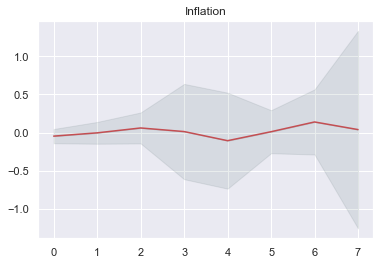

In [14]:
cumSums(res)

In [16]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(res.tvalues, res.params )

,0
-0.04,-0.95
0.04,0.39
0.06,0.43
-0.05,-0.13
-0.12,-0.19
0.12,0.31
0.13,0.42
-0.10,-0.13


In [25]:
r_waldtest = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])
res.wald_test(r_waldtest)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[91.8950607]], p-value=1.9165811974320725e-16, df_denom=8>